In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Github/brianhelenfakenews/

Train: ISOT + ReCOVery + FA-KES

Test: ISOT, ReCOVery, FA-KES (individually)

In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14224340685091967563
, name: "/device:DML:0"
device_type: "DML"
memory_limit: 7355426407
locality {
}
incarnation: 4610508513113645379
physical_device_desc: "{\"name\": \"AMD Radeon RX 5700 XT\", \"vendor_id\": 4098, \"device_id\": 29471, \"driver_version\": \"30.0.13023.1012\"}"
]


In [5]:
true = pd.read_csv("../Datasets/ISOT/True.csv", dtype=str)
fake = pd.read_csv ("../Datasets/ISOT/Fake.csv", dtype=str)
true.head()
fake.head()

,title,text,subject,date,label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
true = true.loc[:, ~true.columns.str.contains('^Unnamed')]
fake = fake.loc[:, ~fake.columns.str.contains('^Unnamed')]
fake = fake.drop(columns=fake.columns[0])
fake = fake.drop(columns=fake.columns[1])
fake = fake.drop(columns=fake.columns[1])
true = true.drop(columns=true.columns[0])
true = true.drop(columns=true.columns[1])
true = true.drop(columns=true.columns[1])

In [7]:
true = shuffle(true, random_state=0)
fake = shuffle(fake, random_state=0)

In [8]:
truetrainpercentage = round(len(true)*0.8)
truetotal = len(true)
faketrainpercentage = round(len(fake)*0.8)
faketotal = len(fake)

In [9]:
truetrain = true[0:truetrainpercentage]
truetest = true[truetrainpercentage:truetotal]
faketrain = fake[0:faketrainpercentage]
faketest = fake[faketrainpercentage:faketotal]

In [10]:
fa_kes = pd.read_csv("../Datasets/FA-KESDataset/FA-KES-Dataset.csv")
recovery = pd.read_csv("../Datasets/ReCOVery/recovery-news-data.csv")

In [11]:
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[2])
fa_kes

,text,label
0,Wed 05 Apr 2017 Syria attack symptoms consiste...,0
1,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,0
2,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,0
3,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,0
4,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,0
...,...,...
799,28-08-2016 Turkish Bombardment Kills 20 Civili...,1
800,17-08-2016 Martyrs as Terrorists Shell Aleppos...,1
801,03-08-2016 Chemical Attack Kills Five Syrians ...,0
802,01-08-2016 5 Killed as Russian Military Choppe...,1


In [12]:
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[1])
recovery = recovery.drop(columns=recovery.columns[1])
recovery

,text,label
0,\nA novel respiratory virus that originated in...,1
1,Chinese Health Officials: More Die From Newly ...,1
2,Public health experts around the globe are scr...,1
3,The first two coronavirus cases in Europe have...,0
4,"A new coronavirus appeared in Wuhan, China, at...",1
...,...,...
2024,© Robert Gauthier/Los Angeles Times/TNS People...,0
2025,"Michael Moore, for decades on the political fr...",0
2026,© HEATHER KHALIFA/The Philadelphia Inquirer/TN...,0
2027,Nearly half of the Twitter accounts sharing in...,0


In [13]:
fa_kes = shuffle(fa_kes, random_state=0)
recovery = shuffle(recovery, random_state=0)

In [14]:
fa_kestrainpercentage = round(len(fa_kes)*0.8)
fa_kestotal = len(fa_kes)
recoverytrainpercentage = round(len(recovery)*0.8)
recoverytotal = len(recovery)

fa_kestrain = fa_kes[0:fa_kestrainpercentage]
fa_kestest = fa_kes[fa_kestrainpercentage:fa_kestotal]
recoverytrain = recovery[0:recoverytrainpercentage]
recoverytest = recovery[recoverytrainpercentage:recoverytotal]

In [15]:
trainframes = [truetrain, faketrain]
train = pd.concat(trainframes)
train = shuffle(train, random_state=0)

In [16]:
isottestframes = [truetest, faketest]
isottest = pd.concat(isottestframes)
isottest = shuffle(isottest, random_state=0)

In [17]:
train

,text,label
18300,The hate for the Trump family by the defeated ...,0
19237,"BERLIN/GREIFSWALD, Germany (Reuters) - German ...",1
156,If Hillary Clinton got into a fistfight with J...,0
21102,Nah nah nah nah hey hey hey good bye Support f...,0
16722,General Boykin spoke at The Awakening 2016 con...,0
...,...,...
8771,Politicians have been known to do a lot of thi...,0
4085,It was just a simple tweet but Stephen King s ...,0
18378,United Airlines should probably consider an ex...,0
8683,If there s one person that you don t want to m...,0


In [18]:
import spacy
spacy.load('en_core_web_sm')

In [19]:
#!pip install spacy== 3.0.0
#!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\bliu0\appdata\local\temp\pip-req-build-ke8g_sm9
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7691 sha256=4671ff5a6152676e84a3073590545368898f903bfe4f4f0c9b1b523a4739599d
  Stored in directory: C:\Users\bliu0\AppData\Local\Temp\pip-ephem-wheel-cache-fnt4bu_p\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\bliu0\AppData\Local\Temp\pip-req-build-ke8g_sm9'


In [20]:
import preprocess_kgptalkie as ps

In [21]:
train['text'] = train['text'].apply(lambda x: str(x).lower())
isottest['text'] = isottest['text'].apply(lambda x: str(x).lower())
fa_kestest['text'] = fa_kestest['text'].apply(lambda x: str(x).lower())
recoverytest['text'] = recoverytest['text'].apply(lambda x: str(x).lower())

train['text'] = train['text'].apply(lambda x: ps.remove_special_chars(x))
isottest['text'] = isottest['text'].apply(lambda x: ps.remove_special_chars(x))
fa_kestest['text'] = fa_kestest['text'].apply(lambda x: ps.remove_special_chars(x))
recoverytest['text'] = recoverytest['text'].apply(lambda x: ps.remove_special_chars(x))

C:\Users\bliu0\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bliu0\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\bliu0\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [22]:
train

,text,label
18300,the hate for the trump family by the defeated ...,0
19237,berlingreifswald germany reuters german chance...,1
156,if hillary clinton got into a fistfight with j...,0
21102,nah nah nah nah hey hey hey good bye support f...,0
16722,general boykin spoke at the awakening 2016 con...,0
...,...,...
8771,politicians have been known to do a lot of thi...,0
4085,it was just a simple tweet but stephen king s ...,0
18378,united airlines should probably consider an ex...,0
8683,if there s one person that you don t want to m...,0


In [23]:
trainx = [d.split() for d in train['text'].tolist()]
trainy = train['label'].values

isotx = [d.split() for d in isottest['text'].tolist()]
isoty = isottest['label'].values

fa_kesx = [d.split() for d in fa_kestest['text'].tolist()]
fa_kesy = fa_kestest['label'].values

recoveryx = [d.split() for d in recoverytest['text'].tolist()]
recoveryy = recoverytest['label'].values

In [24]:
DIM = 500
trainw2v_model = gensim.models.Word2Vec(sentences=trainx, vector_size=DIM, window=10, min_count=1)

isotw2v_model = gensim.models.Word2Vec(sentences=isotx, vector_size=DIM, window=10, min_count=1)

fa_kesw2v_model = gensim.models.Word2Vec(sentences=fa_kesx, vector_size=DIM, window=10, min_count=1)

recoveryw2v_model = gensim.models.Word2Vec(sentences=recoveryx, vector_size=DIM, window=10, min_count=1)

# size --> vector_size

In [25]:
len(trainw2v_model.wv.key_to_index)

len(isotw2v_model.wv.key_to_index)

len(fa_kesw2v_model.wv.key_to_index)

len(recoveryw2v_model.wv.key_to_index)

28115

In [26]:
traintokenizer = tf.keras.preprocessing.text.Tokenizer()
traintokenizer.fit_on_texts(trainx)
traintokenizer.fit_on_texts(isotx)
traintokenizer.fit_on_texts(fa_kesx)
traintokenizer.fit_on_texts(recoveryx)

In [27]:
trainx = traintokenizer.texts_to_sequences(trainx)

isotx = traintokenizer.texts_to_sequences(isotx)

fa_kesx = traintokenizer.texts_to_sequences(fa_kesx)

recoveryx = traintokenizer.texts_to_sequences(recoveryx)

train


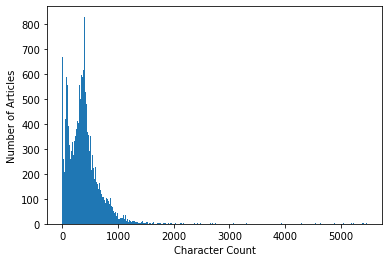

In [28]:
plt.hist([len(a) for a in trainx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("train")
plt.show()

isot


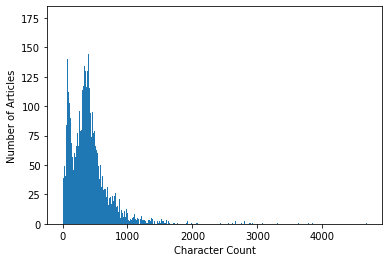

In [29]:
plt.hist([len(a) for a in isotx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("isot")
plt.show()

fa_kes


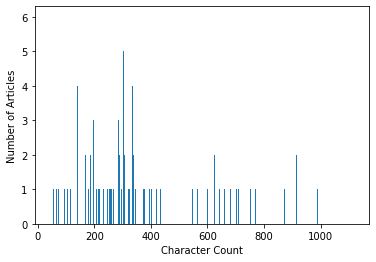

In [30]:
plt.hist([len(a) for a in fa_kesx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("fa_kes")
plt.show()

recovery


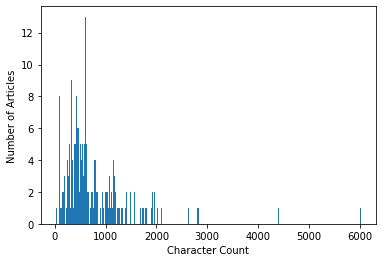

In [31]:
plt.hist([len(a) for a in recoveryx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("recovery")
plt.show()

In [32]:
trainnos = np.array([len(a) for a in trainx])
len(trainnos[trainnos>1000])

isotnos = np.array([len(a) for a in isotx])
len(isotnos[isotnos>1000])

fa_kesnos = np.array([len(a) for a in fa_kesx])
len(fa_kesnos[fa_kesnos>1000])

recoverynos = np.array([len(a) for a in recoveryx])
len(recoverynos[recoverynos>1000])

100

In [33]:
maxlen = 100
trainx = tf.keras.preprocessing.sequence.pad_sequences(trainx, maxlen=maxlen)

isotx = tf.keras.preprocessing.sequence.pad_sequences(isotx, maxlen=maxlen)

fa_kesx = tf.keras.preprocessing.sequence.pad_sequences(fa_kesx, maxlen=maxlen)

recoveryx = tf.keras.preprocessing.sequence.pad_sequences(recoveryx, maxlen=maxlen)

In [34]:
trainvocab_size = len(traintokenizer.word_index) + 1
trainvocab = traintokenizer.word_index

#isotvocab_size = len(isottokenizer.word_index) + 1
#isotvocab = isottokenizer.word_index

#fa_kesvocab_size = len(fa_kestokenizer.word_index) + 1
#fa_kesvocab = fa_kestokenizer.word_index

#recoveryvocab_size = len(recoverytokenizer.word_index) + 1
#recoveryvocab = recoverytokenizer.word_index

In [35]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((trainvocab_size, DIM))
    
    for word, i in trainvocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [36]:
embedding_vectors = get_weight_matrix(trainw2v_model)

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

In [37]:
embedding_vectors.shape

(238222, 500)

In [38]:
testx = np.concatenate((isotx, recoveryx, fa_kesx))
testy = np.concatenate((isoty, recoveryy, fa_kesy))

testx = shuffle(testx, random_state = 60)
testy = shuffle(testy, random_state = 60)
# try changing ths

In [39]:
trainy = trainy.astype(int)
testy = testy.astype(int)

In [40]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)

0.8.1


In [41]:
oversample = RandomOverSampler(sampling_strategy='auto')
trainx, trainy = oversample.fit_resample(trainx, trainy)

In [46]:
model = Sequential()
# add drop layers and simplify neural netowkr (decrease neurons) -- basically look up how to stop overfitting

model.add(Embedding(trainvocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(8, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=5, padding="valid"))
model.add(LSTM(2))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 500)          119111000 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 8)             20008     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 119,131,099
Trainable params: 20,099
Non-trainable params: 119,111,000
_________________________________________________________________


In [47]:
len(trainx)

37604

In [48]:
trainx = np.array(trainx)
trainy = np.array(trainy)

isotx = np.array(isotx)
isoty = np.array(isoty)

fa_kesx = np.array(fa_kesx)
fa_kesy = np.array(fa_kesy)

recoveryx = np.array(recoveryx)
recoveryy = np.array(recoveryy)

In [84]:
model.fit(trainx, trainy, epochs=10, batch_size=64)
#loss 0.8

Train on 37604 samples
Epoch 1/10
37604/37604 [==============================] - 14s 378us/sample - loss: 0.0262 - acc: 0.9936 - recall_2: 0.9951 - precision_2: 0.9921 - true_negatives_2: 18653.0000 - true_positives_2: 18710.0000 - false_positives_2: 149.0000 - false_negatives_2: 92.0000
Epoch 2/10
37604/37604 [==============================] - 14s 375us/sample - loss: 0.0232 - acc: 0.9947 - recall_2: 0.9959 - precision_2: 0.9935 - true_negatives_2: 18680.0000 - true_positives_2: 18725.0000 - false_positives_2: 122.0000 - false_negatives_2: 77.0000
Epoch 3/10
37604/37604 [==============================] - 14s 379us/sample - loss: 0.0236 - acc: 0.9943 - recall_2: 0.9960 - precision_2: 0.9927 - true_negatives_2: 18664.0000 - true_positives_2: 18727.0000 - false_positives_2: 138.0000 - false_negatives_2: 75.0000
Epoch 4/10
37604/37604 [==============================] - 14s 376us/sample - loss: 0.0269 - acc: 0.9930 - recall_2: 0.9946 - precision_2: 0.9914 - true_negatives_2: 18639.0000 - t

In [85]:
model.evaluate(isotx, isoty)

8983/8983 [==============================] - 3s 300us/sample - loss: 0.2083 - acc: 0.9506 - recall_2: 0.9374 - precision_2: 0.9580 - true_negatives_2: 4524.0000 - true_positives_2: 4015.0000 - false_positives_2: 176.0000 - false_negatives_2: 268.0000


[0.20830997380061625,
 0.9505733,
 0.93742704,
 0.9580053,
 4524.0,
 4015.0,
 176.0,
 268.0]

In [86]:
model.evaluate(recoveryx, recoveryy)

406/406 [==============================] - 0s 315us/sample - loss: 2.4609 - acc: 0.5394 - recall_2: 0.4708 - precision_2: 0.7544 - true_negatives_2: 90.0000 - true_positives_2: 129.0000 - false_positives_2: 42.0000 - false_negatives_2: 145.0000


[2.460948567085078,
 0.53940886,
 0.4708029,
 0.75438595,
 90.0,
 129.0,
 42.0,
 145.0]

In [87]:
model.evaluate(fa_kesx, fa_kesy)

161/161 [==============================] - 0s 352us/sample - loss: 2.4560 - acc: 0.5528 - recall_2: 0.9310 - precision_2: 0.5510 - true_negatives_2: 8.0000 - true_positives_2: 81.0000 - false_positives_2: 66.0000 - false_negatives_2: 6.0000


[2.456025620907985, 0.55279505, 0.9310345, 0.5510204, 8.0, 81.0, 66.0, 6.0]

In [88]:
model.evaluate(testx, testy)

9550/9550 [==============================] - 3s 300us/sample - loss: 0.3420 - acc: 0.9264 - recall_2: 0.9098 - precision_2: 0.9370 - true_negatives_2: 4622.0000 - true_positives_2: 4225.0000 - false_positives_2: 284.0000 - false_negatives_2: 419.0000


[0.34197002458751824,
 0.9263874,
 0.9097761,
 0.9370149,
 4622.0,
 4225.0,
 284.0,
 419.0]

In [83]:
testy

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
fake = 0
true = 0

for x in range(len(trainy)):
    if trainy[x] == 0:
        fake += 1
    elif trainy[x] == 1:
        true += 1

fake, true